This notebook presents a method to read *MIDI files* and *MDH5* files from the **LAKH** Dataset and create grakel graphs for future classification. For each midi piece we create 4 grakel graphs based on trajectories on 4 different Tonnetze (T345, T129, T138, T237) and we search it's artist's label in the corresponding *HDF5* file. We store in the same storing format in a different folder.

We can also use this method to store future descriptors.

In the block below we configure the basic function for the setup of the directory. We only use the first 2 functions.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pretty_midi
# import librosa
import mir_eval
import mir_eval.display
import tables
import IPython.display
import os
import json
from tqdm import tqdm
import pickle

# Local path constants
DATA_PATH = 'data'
RESULTS_PATH = 'results'
# Path to the file match_scores.json distributed with the LMD
SCORE_FILE = os.path.join(RESULTS_PATH, 'match_scores.json')
LABELS_FILE = os.path.join(RESULTS_PATH, 'MAGD.csv')
# The Tonnetze used for graph generation
TONNETZEDICT = {'T129': [1, 2, 9], 'T147': [1, 4, 7], 'T237': [2, 3, 7], 'T345': [3, 4, 5]}
# Define the labels we want to find (we can add or remove)
LABELS = ["classic", "rock", "pop", "folk", "metal", "jazz", "disco"]

# Utility functions for retrieving paths
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

def msd_id_to_mp3(msd_id):
    """Given an MSD ID, return the path to the corresponding mp3"""
    return os.path.join(DATA_PATH, 'msd', 'mp3',
                        msd_id_to_dirs(msd_id) + '.mp3')

def msd_id_to_h5(h5):
    """Given an MSD ID, return the path to the corresponding h5"""
    return os.path.join(RESULTS_PATH, 'lmd_matched_h5',
                        msd_id_to_dirs(msd_id) + '.h5')

def get_midi_path(msd_id, midi_md5, kind):
    """Given an MSD ID and MIDI MD5, return path to a MIDI file.
    kind should be one of 'matched' or 'aligned'. """
    return os.path.join(RESULTS_PATH, 'lmd_{}'.format(kind),
                        msd_id_to_dirs(msd_id), midi_md5 + '.mid')

,MSD_ID,LABEL
0,TRAAAAK128F9318786,Pop_Rock
1,TRAAAAV128F421A322,Pop_Rock
2,TRAAAAW128F429D538,Rap
3,TRAAABD128F429CF47,Pop_Rock
4,TRAAACV128F423E09E,Pop_Rock


We show how *MIDI* files are arranged and what can we get from the json scores file.

In [3]:
with open(SCORE_FILE) as f:
    scores = json.load(f)
# Grab a Million Song Dataset ID from the scores dictionary
msd_id = list(scores.keys())[1]
print('Million Song Dataset ID {} has {} MIDI file matches:'.format(
    msd_id, len(scores[msd_id])))
for midi_md5, score in scores[msd_id].items():
    print( '  {} with confidence score {}'.format(midi_md5, score))

    print(msd_id_to_dirs(msd_id))

Million Song Dataset ID TRWMHMP128EF34293F has 2 MIDI file matches:
  c3da6699f64da3db8e523cbbaa80f384 with confidence score 0.7321245522741104
W/M/H/TRWMHMP128EF34293F
  d8392424ea57a0fe6f65447680924d37 with confidence score 0.7476196649194942
W/M/H/TRWMHMP128EF34293F


We show how to read the HDF5 *.h5* file :

In [ ]:
with tables.open_file(msd_id_to_h5(msd_id)) as h5:
    print('ID: {}'.format(msd_id))
    print('"{}" by {} on "{}"'.format(
        h5.root.metadata.songs.cols.title[0],
        h5.root.metadata.songs.cols.artist_name[0],
        h5.root.metadata.songs.cols.release[0]))
    print('Top 5 artist terms:', b", ".join(list(h5.root.metadata.artist_terms)[:5]))

In [3]:
def find_genre_label(msd_id):
    '''Find the genre of a piece given its msd_id'''
    with tables.open_file(msd_id_to_h5(msd_id)) as h5:
        for artist_term in list(h5.root.metadata.artist_terms):
            # transform bytes object to string
            artist_term = artist_term.decode()
            for label in LABELS:
                if label in artist_term:
                    return label
        else:
            return "other"

from hdf5_getters import *

def get_song_info(msd_id):
    '''Extract info from a HDF5 given its msd_id'''
    infodict = dict()
    with tables.open_file(msd_id_to_h5(msd_id)) as h5:

        infodict["key"]= get_key(h5)
        infodict["key_confidence"]= get_key_confidence(h5)
        infodict["mode"]= get_mode(h5)
        infodict["tempo"]= get_tempo(h5)
        infodict["time_signature"]= get_time_signature(h5)
        infodict["time_signature_confidence"]= get_time_signature_confidence(h5)
        infodict["duration"]= get_duration(h5)
        
#         infodict["get_sections_start"] = get_sections_start(h5)
#         infodict["segments_start"] = get_segments_start(h5)
#         infodict["segments_pitches"] = get_segments_pitches(h5)
#         infodict["segments_timbre"] = get_segments_timbre(h5)
#         infodict["segments_confidence"] = get_segments_confidence(h5)

#         infodict["loudness"]= get_loudness(h5)
#         infodict["energy"]= get_energy(h5)
#         infodict["sample_rate"]= get_analysis_sample_rate(h5)

    return infodict

In [5]:
print(find_genre_label(msd_id))
print(get_song_info(msd_id))

disco
{'key': 11, 'key_confidence': 0.334, 'mode': 1, 'tempo': 109.842, 'time_signature': 1, 'time_signature_confidence': 0.0, 'duration': 203.31057}


### Some Definitions
Midi parsing and jsymbolics

In [3]:
import ast
import music21

def jSymbolic_stat(parsed_midi):
    # retrieve statistics from jSymbolic (we can add or remove easily)
    return {'arpegiation_amount': music21.features.jSymbolic.AmountOfArpeggiationFeature(parsed_midi).extract().vector,
        'av_melodic_int': music21.features.jSymbolic.AverageMelodicIntervalFeature(parsed_midi).extract().vector, #Sometimes causes error
        'av_note_dur': music21.features.jSymbolic.AverageNoteDurationFeature(parsed_midi).extract().vector,
        'av_num_of_ind_voices': music21.features.jSymbolic.AverageNumberOfIndependentVoicesFeature(parsed_midi).extract().vector,
        'av_time_bet_att': music21.features.jSymbolic.AverageTimeBetweenAttacksFeature(parsed_midi).extract().vector,
        'importance_of_bass': music21.features.jSymbolic.ImportanceOfBassRegisterFeature(parsed_midi).extract().vector,
        'importance_of_mid': music21.features.jSymbolic.ImportanceOfMiddleRegisterFeature(parsed_midi).extract().vector,
        'importance_of_high': music21.features.jSymbolic.ImportanceOfHighRegisterFeature(parsed_midi).extract().vector,
    }

def get_chords(parsed_midi):
    mChords = parsed_midi.chordify()
    chordList = []
    for c in mChords.recurse().getElementsByClass('Chord'):
        chordList.append(c.orderedPitchClasses)    
    N = len(chordList)
    chordListNoDoubles = []
    sl = [str(i) for i in chordList]
    chordListNoDoubles.append(chordList[0])
    for i in range(1, N):
        if sl[i] != sl[i - 1]:
            chordListNoDoubles.append(ast.literal_eval(sl[i]))
    return chordListNoDoubles
    

Below the code to generate graphs and descriptors and save them in local directory

In [5]:
import joblib
from TrajectoryCalculationsWithClass import NewTrajectory
from graph_creation import createGrakel, createNX
from FirstNotePosition import PlaceFirstNote


with open(SCORE_FILE) as f:
    # The json SCORE_FILE is a dict of ids from Million Dollar
    scores = json.load(f)  
for msd_id in tqdm(scores.keys()):
    # open every directory with midi files and save file dir to var msd_dir
    msd_dir = msd_id_to_dirs(msd_id)
    # add the directory to save the graphs
    graph_directory =  os.path.join(RESULTS_PATH, "lmd_graphs", msd_dir)
    if not os.path.exists(graph_directory):
        os.makedirs(graph_directory)
    # find the label of the piece:
#     label = find_genre_label(msd_id)
    # search midi files in the directory and create the graphs which we save to graph_directory with the same organisation.
    directory = os.path.join(RESULTS_PATH, "lmd_aligned", msd_id_to_dirs(msd_id))
    for midi_file in os.listdir(directory):
        if midi_file.endswith(".mid"):
            if not os.path.exists(os.path.join(graph_directory, os.path.splitext(midi_file)[0] + "_graph_T345.p")):
                print("lol")
                try:
                    s = music21.converter.parse(os.path.join(directory, midi_file))
                    chordlist  = get_chords(s)
                    # Add descriptors and store from jSymbolic
        #             j_stats = jSymbolic_stat(s)
        #             pickle.dump(j_stats, open(os.path.join(graph_directory, os.path.splitext(midi_file)[0] + "_jSymbolic.p"), "wb"))
                    # store graphs of Tonnetze
                    for key, tonnetz in TONNETZEDICT.items():
                        trajectory = NewTrajectory(chordlist, tonnetz, PlaceFirstNote(chordlist, tonnetz))
                        graph = createNX(trajectory)
                        pickle.dump(graph, open(os.path.join(graph_directory, os.path.splitext(midi_file)[0] + "_graph_"+key+".p"), "wb"))
                except Exception as e:
                    pass
#     break

  2%|▏         | 694/31034 [00:02<01:35, 317.73it/s]

lol


  3%|▎         | 1082/31034 [00:11<08:17, 60.25it/s]

lol


  4%|▍         | 1166/31034 [00:14<09:07, 54.59it/s]

lol


  4%|▍         | 1183/31034 [00:20<1:33:37,  5.31it/s]

[10, 4, 5, 6, 8, 2] dict_items([(10, (103, 102)), (4, (103, 104)), (5, (104, 103)), (6, (102, 102)), (2, (104, 102))]) (103, 102) 7 6 5


  4%|▍         | 1395/31034 [00:23<10:26, 47.34it/s]  

lol


  5%|▌         | 1652/31034 [00:29<06:06, 80.10it/s]

lol
lol
lol
lol
lol
lol
lol
lol
lol


  5%|▌         | 1652/31034 [00:40<06:06, 80.10it/s]

lol
lol
lol
lol


  6%|▌         | 1712/31034 [00:46<46:44, 10.46it/s]  

lol
lol
lol
lol
lol


  6%|▌         | 1938/31034 [01:04<06:54, 70.25it/s]   

lol


  7%|▋         | 2078/31034 [01:07<06:26, 74.88it/s]

lol


  8%|▊         | 2599/31034 [01:15<05:31, 85.90it/s] 

lol
lol


  9%|▉         | 2731/31034 [01:22<08:07, 58.05it/s]  

lol


 11%|█         | 3401/31034 [01:31<04:41, 98.16it/s] 

lol
lol
lol


 11%|█         | 3437/31034 [01:39<34:30, 13.33it/s]  

lol


 11%|█         | 3467/31034 [01:42<13:32, 33.92it/s]  

lol


KeyboardInterrupt: 

Check what is writen:

In [7]:
# with open(SCORE_FILE) as f:
    # The json SCORE_FILE is a dict of ids from Million Dollar
    scores = json.load(f)  
for msd_id in tqdm(scores.keys()):
    # open every directory with midi files and save file dir to var msd_dir
    msd_dir = msd_id_to_dirs(msd_id)
    # add the directory to save the graphs
    graph_directory =  os.path.join(RESULTS_PATH, "lmd_graphs", msd_dir)
    # probably this for should be on the outer shell.
    for key, tonnetz in TONNETZEDICT.items():
        for file in os.listdir(graph_directory):
            if file.endswith(key+".p"):
                print(pickle.load( open( os.path.join(graph_directory, file), "rb" ) ))
        break
    break
    

  0%|          | 0/31034 [00:00<?, ?it/s]

['rock', <networkx.classes.graph.Graph object at 0x0000026C87430460>]


## LABEL MANAGING

Here we see how to manipulate file extensions containing labels to other more pliable formats

In [5]:
import pandas as pd 
# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 
labels = pd.read_csv(LABELS_FILE, sep=';')

# transform csv to Dict
labelsDict = dict(zip(list(labels.MSD_ID), list(labels.LABEL)))
# save Dict as json
with open(os.path.join(RESULTS_PATH, 'MAGD.json'), 'w') as f:
    json.dump(labelsDict, f)

### Trial Classification

##### We try a graph kernel method by first reading the Data

In [4]:
with open(SCORE_FILE) as f:
    # The json SCORE_FILE is a dict of ids from Million Dollar
    scores = json.load(f)
y = list()
G = list()
for msd_id in tqdm(scores.keys()):
    # open every directory with midi files and save file dir to var msd_dir
    msd_dir = msd_id_to_dirs(msd_id)
    # add the directory where graphs where saved
    graph_directory =  os.path.join(RESULTS_PATH, "lmd_graphs", msd_dir)
    # first check if the directory isn't empty
    if os.listdir(graph_directory):
        for file in os.listdir(graph_directory):
            if file.endswith("T345.p"):
                Gi = pickle.load( open( os.path.join(graph_directory, file), "rb" ) )
                yi = pickle.load( open( os.path.join(graph_directory, file.split("_graph_T345.p")[0]+ "_label.p"), "rb" ) )
                if yi != None:
                    y.append(yi)
                    G.append(Gi)

100%|██████████| 31034/31034 [17:46<00:00, 29.10it/s]  


After this step we have the the labels together with the graph on the selected Tonnetz, i.e. *T345*. We can now do the classification as usual.


In [5]:
print("We have", len(y), "labels")
print("and", len(G), "graphs")

for label in LABELS+["other"]:
    print('{} has occurred {} times'.format(label, y.count(label)) )

We have 17489 labels
and 17489 graphs
classic has occurred 1111 times
rock has occurred 6468 times
pop has occurred 4714 times
folk has occurred 413 times
metal has occurred 524 times
jazz has occurred 1917 times
disco has occurred 1118 times
other has occurred 1224 times


In [6]:
from sklearn.model_selection import train_test_split
from grakel.utils import graph_from_networkx

# Transform networkx graphs to grakel representations
G = list(graph_from_networkx(G, node_labels_tag='note'))

# Splits the dataset into a training and a test set
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.3, shuffle=True, stratify=y)

/cal/homes/karystinaios/.conda/envs/myenv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.lfw module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
from grakel.kernels import WeisfeilerLehman, GraphletSampling
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# Uses the WEisfeilerLehman kernel to generate the kernel matrices
gk = WeisfeilerLehman(n_iter=4, normalize=True)
K_train = gk.fit_transform(G_train)
K_test = gk.transform(G_test)

# Uses the SVM classifier to perform classification
clf = SVC(kernel="precomputed")
clf.fit(K_train, y_train)
y_pred = clf.predict(K_test)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", str(round(acc*100, 2)) + "%")

Accuracy: 51.72%


### Compute Classification Metrics

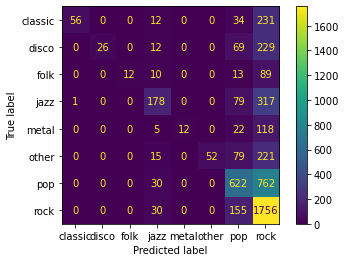

In [22]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score

clf_conf = plot_confusion_matrix(clf, K_test, y_test)

### Plot Learning Curve

# Classification via merging disconnected subgraphs into a Big Graph.

Taking the disjoint union for all graphs per datapoint merging in a single big graph for classification via kernels.

In [7]:
import networkx as nx

with open(SCORE_FILE) as f:
    # The json SCORE_FILE is a dict of ids from Million Dollar
    scores = json.load(f)
y = list()
Gi = dict()
G = list()
for msd_id in tqdm(scores.keys()):
    # open every directory with midi files and save file dir to var msd_dir
    msd_dir = msd_id_to_dirs(msd_id)
    # add the directory where graphs where saved
    graph_directory =  os.path.join(RESULTS_PATH, "lmd_graphs", msd_dir)
    # first check if the directory isn't empty
    if os.listdir(graph_directory):
        IsGraphDir = False
        for key, tonnetz in TONNETZEDICT.items():
            for file in os.listdir(graph_directory):
                if file.endswith(key +".p"):
                    Gi[key] = pickle.load( open( os.path.join(graph_directory, file), "rb" ) )
                    yi = pickle.load( open( os.path.join(graph_directory, file.split("_graph_" +key+".p")[0]+ "_label.p"), "rb" ) )
                    IsGraphDir = True
        # the disjoint union of graphs (have to chek if a graph exists)
        if IsGraphDir:
            U = nx.disjoint_union(Gi["T345"], nx.disjoint_union(Gi["T129"], nx.disjoint_union(Gi["T237"], Gi["T147"])))
            G.append(U)
            y.append(yi)

100%|██████████| 31034/31034 [06:47<00:00, 76.09it/s] 


In [8]:
print("We have", len(y), "labels")
print("and", len(G), "graphs")

for label in LABELS+["other"]:
    print('{} has occurred {} times'.format(label, y.count(label)) )

We have 4538 labels
and 4538 graphs
classic has occurred 319 times
rock has occurred 1682 times
pop has occurred 1291 times
folk has occurred 72 times
metal has occurred 203 times
jazz has occurred 349 times
disco has occurred 347 times
other has occurred 275 times


Perform The Classification

In [9]:
from sklearn.model_selection import train_test_split
from grakel.utils import graph_from_networkx

# Transform networkx graphs to grakel representations
G = list(graph_from_networkx(G, node_labels_tag='note'))

# Splits the dataset into a training and a test set
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.3, shuffle=True, stratify=y)

/cal/homes/karystinaios/.conda/envs/myenv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.lfw module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [12]:
from grakel.kernels import WeisfeilerLehman, GraphletSampling
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# Uses the WEisfeilerLehman kernel to generate the kernel matrices
gk = WeisfeilerLehman(n_iter=4, normalize=True)
K_train = gk.fit_transform(G_train)
K_test = gk.transform(G_test)

# Uses the SVM classifier to perform classification
clf = SVC(kernel="precomputed")
clf.fit(K_train, y_train)
y_pred = clf.predict(K_test)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", str(round(acc*100, 2)) + "%")

Accuracy: 37.3%


### Classification via Boosting

In this section we apply the simple classification for every graph and the descriptors retrieved from the HMD5 files seperately and then we combine the results with a boosting learning algorithm.

In [13]:
with open(SCORE_FILE) as f:
    # The json SCORE_FILE is a dict of ids from Million Dollar
    scores = json.load(f)
y = { k : list() for k in TONNETZEDICT.keys()}
G = { k : list() for k in TONNETZEDICT.keys()}
for msd_id in tqdm(scores.keys()):
    # open every directory with midi files and save file dir to var msd_dir
    msd_dir = msd_id_to_dirs(msd_id)
    # add the directory where graphs where saved
    graph_directory =  os.path.join(RESULTS_PATH, "lmd_graphs", msd_dir)
    # first check if the directory isn't empty
    if os.listdir(graph_directory):
        for key, tonnetz in TONNETZEDICT.items():
            for file in os.listdir(graph_directory):
                if file.endswith(key +".p"):
                    Gi = pickle.load( open( os.path.join(graph_directory, file), "rb" ) )
                    yi = pickle.load( open( os.path.join(graph_directory, file.split("_graph_" +key+".p")[0]+ "_label.p"), "rb" ) )
                    y[key].append(yi)
                    G[key].append(Gi)

100%|██████████| 31034/31034 [06:13<00:00, 83.03it/s]  


In [14]:
print("We have", len(y["T345"]), "labels")
print("and", len(G["T345"]), "graphs")

for label in LABELS+["other"]:
    print('{} has occurred {} times'.format(label, y["T147"].count(label)) )

We have 17489 labels
and 17489 graphs
classic has occurred 1111 times
rock has occurred 6469 times
pop has occurred 4714 times
folk has occurred 413 times
metal has occurred 524 times
jazz has occurred 1917 times
disco has occurred 1118 times
other has occurred 1224 times


In [30]:
len(y['T129'])

17490

In [32]:
from sklearn.model_selection import train_test_split
from grakel.kernels import WeisfeilerLehman, GraphletSampling
from sklearn.svm import SVC

G_train = dict()
G_test = dict()
K_train = dict() 
K_test = dict()
clf = dict()
y_pred = dict()

for key in TONNETZEDICT.keys():  
    # Transform networkx graphs to grakel representations
    G[key] = list(graph_from_networkx(G[key], node_labels_tag='note'))
    # do not shuffle the split
    G_train[key], G_test[key], y_train, y_test = train_test_split(G[key], y[key], test_size=0.3, shuffle=False, stratify=y)
    gk = WeisfeilerLehman(n_iter=1, normalize=True)
    K_train[key] = gk.fit_transform(G_train[key])
    K_test[key] = gk.transform(G_test[key])
    y_pred[key] = clf[key].predict(K_test[key])

AttributeError: 'list' object has no attribute 'nodes'